<a href="https://colab.research.google.com/github/van-dang/MRI-Cloud/blob/master/StrongPeriodicBC_TwoComp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#About the solver

In [0]:
# This demo solves the transformed Bloch-Torrey equation applied to diffusion MRI 
# using the standard finite element method coupled with the theta-method 
# for the space discretization.

# This demo allows for a two-compartment domain with periodic boundaries and the 
# spins can enter and exit the computational domain freely by using the periodic 
# boundary conditions

# Copyright (C) 2017 Van-Dang Nguyen

# This file is part of DOLFIN.

# DOLFIN is free software: you can redistribute it and/or modify
# it under the terms of the GNU Lesser General Public License as published by
# the Free Software Foundation, either version 3 of the License, or
# (at your option) any later version.

# DOLFIN is distributed in the hope that it will be useful,
# but WITHOUT ANY WARRANTY; without even the implied warranty of
# MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE. See the
# GNU Lesser General Public License for more details.

# You should have received a copy of the GNU Lesser General Public License
# along with DOLFIN. If not, see <http://www.gnu.org/licenses/>.

# First added:  2017-10-10
# Last changed: 2019-04-10

# Setting a working environment

In [18]:
from google.colab import files

import platform, sys
python_version=platform.python_version()
from distutils.version import LooseVersion, StrictVersion

if ( LooseVersion(python_version) < LooseVersion("3.0.0")):
    print("Python3 is needed!");
    print("How to fix: Runtime/Change_runtime_type/Python 3");
    sys.exit()
    
try:
    from dolfin import *; from mshr import *
except ImportError as e:
    !apt-get install -y -qq software-properties-common python-software-properties module-init-tools
    !add-apt-repository -y ppa:fenics-packages/fenics
    !apt-get update -qq
    !apt install -y --no-install-recommends fenics
    from dolfin import *; from mshr import *
    

import matplotlib.pyplot as plt;
from IPython.display import clear_output, display; import time; import dolfin.common.plotting as fenicsplot 
import time

import os, sys, shutil

clear_output(); # Plotting setup

dolfin_version = dolfin.__version__
print ('dolfin version:', dolfin_version)


!rm -rf * # clean up all files

# dolfin setting
q_degree = 3
dx = dx(metadata={'quadrature_degree': q_degree})

# Useful commands
# Remove an empty folder      : os.rmdir("my_results")
# Remove a folder with files  : shutil.rmtree("results")
# Make a folder               : os.mkdir("my_results")
# Runtime/Change_runtime_type/Python3

dolfin version: 2018.1.0


In [0]:
xmin, ymin, xmax, ymax = -10, -10, 10, 10

geo = "circle"

if geo == "circle":
    xc, yc = 0.0, 0.0
    R0, R1 = 5.0, 10.0
    factor =2;
    mresolution=20*factor
    segment0 = 15*factor;
    segment1 = 20*factor;

    domain0 = Circle(Point(xc, yc), R0, segment0)
    # domain  = Circle(Point(xc, yc), R1, segment1)
    domain = Rectangle(Point(xmin, ymin), Point(xmax, ymax))

    domain.set_subdomain(1, domain0)
    mesh = generate_mesh(domain, mresolution)
else:
    eps = 1e-4;
    nx, ny = 10, 10;
    factor = 1;
    mesh = RectangleMesh(Point(xmin, ymin), Point(xmax, ymax), factor*nx, factor*ny, "right")

hmin = mesh.hmin();
class Exterior(SubDomain):
    def inside (self,x,on_boundary):
        if geo=="circle":
            d = sqrt((x[0])*(x[0])+(x[1])*(x[1]));
            return d>=R0-hmin/4.0;
        else:
            return x[0]*x[0]>4*4-hmin/10. or x[1]*x[1]>4*4-hmin/10.

class Interior(SubDomain):
    def inside (self,x,on_boundary):
        exterior = Exterior()
        return not(exterior.inside(x, True))
# Mark exterior domain to 1, interior domain to 0
exterior = Exterior();
interior = Interior();
cellmarker = MeshFunction("size_t", mesh, mesh.topology().dim())
cellmarker.set_all(0)
exterior.mark(cellmarker,1)

mesh0 = SubMesh(mesh, cellmarker, 0)
mesh1 = SubMesh(mesh, cellmarker, 1)
V_DG = FunctionSpace(mesh, 'DG', 0)
dofmap_DG = V_DG.dofmap()
phase = Function(V_DG)
vol = CellVolume(mesh)
h = 0.5*CellDiameter(mesh);

for cell in cells(mesh):
    phase.vector()[dofmap_DG.cell_dofs(cell.index())] = cellmarker[cell.index()];

# plot(phase); interactive(); stop
File("mesh.xml") << mesh
File("mesh_cmpt1.xml") << mesh1

#Download the mesh and submesh

In [20]:
'''
!rm -rf *
!wget --quiet https://raw.githubusercontent.com/van-dang/MRI-Cloud/mesh/mesh2comp_R9_periodic.xml.zip
!wget --quiet https://raw.githubusercontent.com/van-dang/MRI-Cloud/mesh/mesh2comp_R9_periodic_cmp1.xml.zip
!unzip -q mesh2comp_R9_periodic.xml.zip
!unzip -q mesh2comp_R9_periodic_cmp1.xml.zip
# Load multilayered torus mesh and submesh
mesh = Mesh("mesh2comp_R9_periodic.xml");  
cmpt_mesh = Mesh('mesh2comp_R9_periodic_cmp1.xml')
'''
# Load multilayered torus mesh and submesh
mesh = Mesh("mesh.xml");  
cmpt_mesh = Mesh('mesh_cmpt1.xml')


hmin = mesh.hmin();
gdim = mesh.geometry().dim()


xmin = mesh.coordinates()[:, 0].min()
xmax = mesh.coordinates()[:, 0].max()

ymin = mesh.coordinates()[:, 1].min()
ymax = mesh.coordinates()[:, 1].max()

zmin, zmax = 0, 0 
if (gdim==3):
  zmin = mesh.coordinates()[:, 2].min()
  zmax = mesh.coordinates()[:, 2].max()
  

print(xmin, ymin, zmin, xmax, ymax, zmax)


tol = 1e-6*mesh.hmin();
gdim = mesh.geometry().dim()

PeriodicDir = [1, 1, 0]

g0, g1, g2 = 1, 0, 0
if gdim==2:
  gdir = Point(g0,g1);

if gdim==3:
  gdir = Point(g0,g1,g2);
  
gdir /= gdir.norm()


tol = 1e-7*mesh.hmin();
class PeriodicBD(SubDomain):
    # Left boundary is "target domain" G
    def inside(self, x, on_boundary):
        return bool(x[0] < xmin + tol and x[0] > xmin - tol and on_boundary)

    # Map right boundary (H) to left boundary (G)
    def map(self, x, y):
        y[0] = x[0] - (xmax-xmin)
        y[1] = x[1]
        if gdim==3:
          y[2] = x[2]

class PeriodicBD(SubDomain):
    # Left boundary is "target domain" G
    def inside(self, x, on_boundary):
        # return True if on left or bottom boundary AND NOT on one of the two corners (0, 1) and (1, 0) 
        bcx = abs(x[0] - xmin)<tol
        bcy = abs(x[1] - ymin)<tol
        bcz = 0
        if (gdim==3):
          bcz = abs(x[2] - zmin) < tol
          
        return bool((bcx or bcy or bcz) and on_boundary)

    def map(self, x, y):
        Lxx, Lyy, Lzz = 0, 0, 0
        if PeriodicDir[0] == 0:
          Lxx = 1e10;
        if PeriodicDir[1] == 0:
          Lyy = 1e10;
        if PeriodicDir[2] == 0:
          Lzz = 1e10;
          
        if abs(x[0] - xmax) < tol:
            y[0] = x[0] - (xmax-xmin) + Lxx
            y[1] = x[1]
            if (gdim==3):
              y[2] = x[2]
        if abs(x[1] - ymax) < tol:
            y[0] = x[0]
            y[1] = x[1] - (ymax-ymin) + Lyy 
            if (gdim==3):
              y[2] = x[2]
        if (gdim==3) and abs(x[2] - zmax)<tol:
            y[0] = x[0]
            y[1] = x[1]
            y[2] = x[2] - (zmax-zmin) + Lzz

-10.0 -10.0 0 10.0 10.0 0


#Setup phase function

In [0]:

V_DG = FunctionSpace(mesh, 'DG', 0)
dofmap_DG = V_DG.dofmap()
phase = Function(V_DG)
cellmarker = MeshFunction("size_t", mesh, mesh.topology().dim())

for cell in cells(mesh):
    p = cell.midpoint();
    is_in_cmpt = cmpt_mesh.bounding_box_tree().compute_first_entity_collision(p)<4294967295
    phase.vector()[dofmap_DG.cell_dofs(cell.index())] = is_in_cmpt;
    cellmarker[cell.index()] = is_in_cmpt;


# plot(phase, cmap="coolwarm");
mesh0 = SubMesh(mesh, cellmarker, 0)
mesh1 = SubMesh(mesh, cellmarker, 1)
File("Phase.pvd")<<phase
File("mesh0.xml")<<mesh0
File("mesh1.xml")<<mesh1

#Pre-define functions

In [0]:
def SubMeshSave(ur, ui, file_ur, file_ui, mesh, n, stepcounter, dolfin_version):
  if dolfin_version=='1.6.0':
    V = FunctionSpace(mesh, "CG", porder)
  else:
    # For FEniCS 2016, 2017
    Ve = FiniteElement("CG", mesh.ufl_cell(), porder)
    V = FunctionSpace(mesh, Ve)
  if stepcounter % n == 0:
    ur_p = project(ur, V);
    ui_p = project(ui, V);
    ur_p.rename("Real", "label");
    ui_p.rename("Imag", "label");
    file_ur << ur_p;
    file_ui << ui_p;

def ieval(u,omega, phase):
  if omega==1:
    return u('+')*phase('+') + u('-')*phase('-');
  if omega==0:
    return u('+')*(1.-phase('+')) + u('-')*(1.-phase('-'))                              


Nsteps:  50 bvalue:  1000
t: 0.000000  T: 10000.0 dt:200.0 gnorm: 1.095445e-04 Completed 0.00%
t: 400.000000  T: 10000.0 dt:200.0 gnorm: 1.095445e-04 Completed 3.92%
t: 800.000000  T: 10000.0 dt:200.0 gnorm: 1.095445e-04 Completed 7.84%
t: 1200.000000  T: 10000.0 dt:200.0 gnorm: 1.095445e-04 Completed 11.76%
t: 1600.000000  T: 10000.0 dt:200.0 gnorm: 1.095445e-04 Completed 15.69%
t: 2000.000000  T: 10000.0 dt:200.0 gnorm: 1.095445e-04 Completed 19.61%
t: 2400.000000  T: 10000.0 dt:200.0 gnorm: 1.095445e-04 Completed 23.53%
t: 2800.000000  T: 10000.0 dt:200.0 gnorm: 1.095445e-04 Completed 27.45%
t: 3200.000000  T: 10000.0 dt:200.0 gnorm: 1.095445e-04 Completed 31.37%
t: 3600.000000  T: 10000.0 dt:200.0 gnorm: 1.095445e-04 Completed 35.29%
t: 4000.000000  T: 10000.0 dt:200.0 gnorm: 1.095445e-04 Completed 39.22%
t: 4400.000000  T: 10000.0 dt:200.0 gnorm: 1.095445e-04 Completed 43.14%
t: 4800.000000  T: 10000.0 dt:200.0 gnorm: 1.095445e-04 Completed 47.06%
t: 5200.000000  T: 10000.0 dt:200

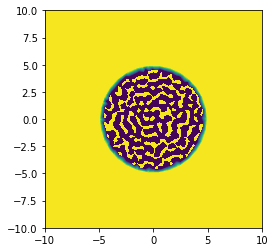

In [23]:
Nsteps = 50;
bvalue = 1000;

delta, Delta = 5000, 5000
t, T = 0, Delta+delta;

k = T/Nsteps


gnorm = sqrt(bvalue)/sqrt(delta*delta*(Delta-delta/3.0));
print("Nsteps: ", Nsteps, "bvalue: ",bvalue)



# parameters
#####################################################################################################################
#####################################################################################################################
porder = 1;

# delta, Delta = 50000, 50000
K0, K1 = 3e-3, 3e-3;

kappa = 1e1; # permeability
# kappa = 100.0; # permeability

nskip = 2;

# bvalue = 1000;
# gnorm = sqrt(bvalue)/sqrt(delta*delta*(Delta-delta/3.0));
#####################################################################################################################
#####################################################################################################################
# Sub domain for Periodic boundary condition


#####################################################################################################################
#####################################################################################################################
# FUNCTION SPACES
if dolfin_version=='1.6.0':
    V = FunctionSpace(mesh , "CG", 1, constrained_domain=PeriodicBD());
    # V = FunctionSpace(mesh , "CG", 1);
    W = MixedFunctionSpace([V, V, V, V])
    VV = MixedFunctionSpace([V, V])
else:
    # For FEniCS 2016, 2017
    Ve = FiniteElement("CG", mesh.ufl_cell(), 1)
    TH = MixedElement([Ve,Ve,Ve,Ve])
    VVe = MixedElement([Ve,Ve])
    V = FunctionSpace(mesh,Ve);
    VV = FunctionSpace(mesh,VVe);
    W = FunctionSpace(mesh, TH, constrained_domain=PeriodicBD())

v = TestFunction(W)
v0r, v0i, v1r, v1i = v[0], v[1], v[2], v[3]

w = TrialFunction(W);
u0r, u0i, u1r, u1i = w[0], w[1], w[2], w[3]
#####################################################################################################################
#####################################################################################################################
# Initial conditions
# one = Function(V);
Dirac_Delta = Expression("x[0]*x[0]+x[1]*x[1]<eps",eps=1e6, domain=mesh, degree=2);
if gdim==3:
  Dirac_Delta = Expression("x[0]*x[0]+x[1]*x[1]+x[2]*x[2]<eps",eps=1e6, domain=mesh, degree=2);
Dirac_Delta = interpolate(Dirac_Delta, V);
# plot(Dirac_Delta); interactive(); stop;
# one.vector()[:] = 1;
u_0 = Function(W);
assign(u_0.sub(0), Dirac_Delta)
assign(u_0.sub(2), Dirac_Delta)
u0r_0, u0i_0, u1r_0, u1i_0 = u_0[0], u_0[1], u_0[2], u_0[3]
#####################################################################################################################
#####################################################################################################################

g = Expression(("g0","g1"), g0=gdir.x(), g1=gdir.y(),domain=mesh,degree=2);

if gdim==3:
  g = Expression(("g0","g1","g2"), g0=gdir.x(), g1=gdir.y(), g2=gdir.z(),domain=mesh,degree=2);

#####################################################################################################################
#####################################################################################################################
## output files 
file_u0r = File("results/u0r.pvd")
file_u0i = File("results/u0i.pvd")
file_u1r = File("results/u1r.pvd")
file_u1i = File("results/u1i.pvd")
#####################################################################################################################
#####################################################################################################################
def FT(t, delta, Delta):
    ft1 = 1.0*(t>=0 and t<delta) 
    ft2 = -1.0*(t>=Delta and t<=Delta+delta);
    return ft1 + ft2;  

def iFT(t, delta, Delta): # integrate ft
    ft1 = t*(t>=0 and t<delta) 
    ft2 = delta*(t>=delta and t<Delta) 
    ft3 = (delta - t + Delta)*(t>=Delta and t<=Delta+delta) 
    return ft1 + ft2 + ft3;  

stepcounter = 0;
####################################################################################################################
####################################################################################################################
def FuncF(ift, gnorm, g, ur, ui, vr, vi, K):
    Fr =   ift*gnorm*(inner(g,K*grad(ui))+inner(grad(ui),K*g))*vr - inner(g,K*g)*gnorm*gnorm*ift*ift*ur*vr-K*inner(grad(ur), grad(vr))
    Fi = - ift*gnorm*(inner(g,K*grad(ur))+inner(grad(ur),K*g))*vi - inner(g,K*g)*gnorm*gnorm*ift*ift*ui*vi-K*inner(grad(ui), grad(vi))
    return Fr + Fi

def icondition(kappa, u0rm, u1rm, v0r, v1r, u0im, u1im, v0i, v1i):
    F_bcr = kappa*(u0rm-u1rm)*(v0r-v1r)
    F_bci = kappa*(u0im-u1im)*(v0i-v1i)
    return F_bcr + F_bci

def inner_interface(kappa, u0rm, u1rm, v0r, v1r, u0im, u1im, v0i, v1i, n, g, K0, K1):
    F_bcr  = (-kappa*avg(u0rm-u1rm)-0.5*gnorm*ift*(avg(u0im)*inner(K0*avg(g),n)+avg(u1im)*inner(K1*avg(g),n)))*avg(v0r-v1r)                      
    F_bcr += -gnorm*ift*( avg(u0im)*inner(K0*avg(g),n)-avg(u1im)*inner(K1*avg(g),n) )*0.5*avg(v0r+v1r)                                         
                                                                                                                                                
    F_bci  = (-kappa*avg(u0im-u1im)+0.5*gnorm*ift*(avg(u0rm)*inner(K0*avg(g),n)+avg(u1rm)*inner(K0*avg(g),n)))*avg(v0i-v1i)                      
    F_bci += gnorm*ift*(  avg(u0rm)*inner(K0*avg(g),n)-avg(u1rm)*inner(K1*avg(g),n) )*0.5*avg(v0i+v1i)                                         


    return -F_bcr - F_bci

def outer_interface(ift, gnorm, K, n, ur, ui, vr, vi, g):
    F_bcr =  (ift*gnorm+1e-16)*inner(K*g, n)*ui*vr
    F_bci = -(ift*gnorm+1e-16)*inner(K*g, n)*ur*vi
    return F_bcr + F_bci

#############################################################################################################################
#############################################################################################################################
def ThetaMethod_L(ift, gnorm, g, u0r, u0i, v0r, v0i, u1r, u1i, v1r, v1i, u0r_0, u0i_0, u1r_0, u1i_0,k, kappa, K0, K1, theta, phase,n, n0):
    L0 = (u0r_0/k*v0r + u0i_0/k*v0i +theta*FuncF(ift, gnorm, g, u0r_0, u0i_0, v0r, v0i, K0))*(1-phase)*dx
    L1 = (u1r_0/k*v1r + u1i_0/k*v1i +theta*FuncF(ift, gnorm, g, u1r_0, u1i_0, v1r, v1i, K1))*phase*dx
    L_inner_bc  = -(theta*inner_interface(kappa, u0r_0, u1r_0, v0r, v1r, u0i_0, u1i_0, v0i, v1i, n0, g, K0, K1))*abs(jump(phase))*dS;
    L0_outer_bc = -theta*outer_interface(ift, gnorm, K0, n, u0r_0, u0i_0, v0r, v0i, g)*ds
    L1_outer_bc = -theta*outer_interface(ift, gnorm, K1, n, u1r_0, u1i_0, v1r, v1i, g)*ds
    return L0+L1+L_inner_bc + L0_outer_bc+L1_outer_bc

def MassMatrix(u0r, u0i, v0r, v0i, u1r, u1i, v1r, v1i, phase):
    m0 = (u0r*v0r   + u0i*v0i)*(1-phase)*dx
    m1 = (u1r*v1r   + u1i*v1i)*phase*dx
    M = assemble(m0+m1);
    M.ident_zeros()
    return M;
  
  
def ThetaMethod_a(ift, gnorm, g, u0r, u0i, v0r, v0i, u1r, u1i, v1r, v1i, u0r_0, u0i_0, u1r_0, u1i_0,k,kappa, K0, K1, theta, phase,n, n0):
    a0 = (u0r/k*v0r   + u0i/k*v0i  -theta*FuncF(ift, gnorm, g, u0r  , u0i  , v0r, v0i, K0))*(1-phase)*dx
    a1 = (u1r/k*v1r   + u1i/k*v1i  -theta*FuncF(ift, gnorm, g, u1r  , u1i  , v1r, v1i, K1))*phase*dx
    a_inner_bc  = (  (theta*inner_interface(kappa, u0r  , u1r  , v0r, v1r, u0i  , u1i  , v0i, v1i, n0, g, K0, K1)))*abs(jump(phase))*dS;
    a0_outer_bc = theta*outer_interface(ift, gnorm ,K0, n, u0r, u0i, v0r, v0i, g)*ds
    a1_outer_bc = theta*outer_interface(ift, gnorm ,K1, n, u1r, u1i, v1r, v1i, g)*ds
    return a0+a1+a_inner_bc + a0_outer_bc + a1_outer_bc

def ThetaMethod_F(ift, gnorm, g, u0r, u0i, v0r, v0i, u1r, u1i, v1r, v1i, u0r_0, u0i_0, u1r_0, u1i_0,k,kappa, K0, K1, theta, phase,n, n0):
    a0 = (  -theta*FuncF(ift, gnorm, g, u0r  , u0i  , v0r, v0i, K0))*(1-phase)*dx
    a1 = (  -theta*FuncF(ift, gnorm, g, u1r  , u1i  , v1r, v1i, K1))*phase*dx
    a_inner_bc  = (  (theta*inner_interface(kappa, u0r  , u1r  , v0r, v1r, u0i  , u1i  , v0i, v1i, n0, g, K0, K1)))*abs(jump(phase))*dS;
    a0_outer_bc = theta*outer_interface(ift, gnorm ,K0, n, u0r, u0i, v0r, v0i, g)*ds
    a1_outer_bc = theta*outer_interface(ift, gnorm ,K1, n, u1r, u1i, v1r, v1i, g)*ds
    return a0+a1+a_inner_bc + a0_outer_bc + a1_outer_bc
  
#############################################################################################################################
#############################################################################################################################
# Theta method

stepcounter = 0;
theta = 0.5;

n = FacetNormal(mesh);
n0 = ieval(n, 0, phase);

M = MassMatrix(u0r, u0i, v0r, v0i, u1r, u1i, v1r, v1i, phase)

start_time = time.time()

solver = PETScLUSolver("mumps")
while t < T + k: # Time-stepping loop
    if stepcounter % nskip == 0:
        print('t: %f '%t, 'T: %.1f'%T, 'dt:%.1f'%k,'gnorm: %e'%gnorm,'Completed %.2f%%'%(float(t)/float(T+k)*100.0));

    ft = FT(t, delta, Delta);
    ift = iFT(t, delta, Delta);

    L = ThetaMethod_L(ift, gnorm, g, u0r, u0i, v0r, v0i, u1r, u1i, v1r, v1i, u0r_0, u0i_0, u1r_0, u1i_0,k, kappa, K0, K1, theta, phase,n, n0);

    A = M/k + assemble(ThetaMethod_F(ift, gnorm, g, u0r, u0i, v0r, v0i, u1r, u1i, v1r, v1i, u0r_0, u0i_0, u1r_0, u1i_0,k, kappa, K0, K1, theta, phase,n, n0) )
    b = assemble(L);
 
    u = Function(W)
    # solve(A,u.vector(),b, "gmres");
    solver.solve(A,u.vector(),b);
    
    u0r_0, u0i_0, u1r_0, u1i_0 = split(u)
    
    SubMeshSave(u0r_0, u0i_0, file_u0r, file_u0i, mesh0, nskip, stepcounter, dolfin_version);
    SubMeshSave(u1r_0, u1i_0, file_u1r, file_u1i, mesh1, nskip, stepcounter, dolfin_version);
    
    t += k;
    stepcounter += 1;

elapsed_time = time.time() - start_time
print("Elapsed time: %f seconds"%elapsed_time)

plot(u0r_0); plot(u1r_0); 
signal = assemble((phase*u1r_0+(1-phase)*u0r_0)*dx)/assemble(Dirac_Delta*dx);

print('b:',bvalue, 'Signal: %.3e'%signal,'kappa: %.3e'%kappa,', dt:',k,', hmin:',hmin, ', Free signal: %.3e'%(exp(-bvalue*K0)))
